In [92]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [156]:
casp = pd.read_csv("CASP.csv")
casp.head()

,RMSD,F1,F2,F3,F4,F5,F6,F7,F8,F9
0,17.284,13558.30,4305.35,0.31754,162.1730,1.872791e+06,215.3590,4287.87,102,27.0302
1,6.021,6191.96,1623.16,0.26213,53.3894,8.034467e+05,87.2024,3328.91,39,38.5468
2,9.275,7725.98,1726.28,0.22343,67.2887,1.075648e+06,81.7913,2981.04,29,38.8119
3,15.851,8424.58,2368.25,0.28111,67.8325,1.210472e+06,109.4390,3248.22,70,39.0651
4,7.962,7460.84,1736.94,0.23280,52.4123,1.021020e+06,94.5234,2814.42,41,39.9147


It is often a good idea to start gathering all information about the data we are trying to use. We will try to extract three layers of information from this dataset. Just to make it easier for us to do this, it is a good idea to wrap these commands into a function **get_dataset_details**. 

Here is a function that prints all the relevant details about the data.

* df.info() provides details about the non-null entries in each column of the dataframe
* df.describe() lists down all the relevant statistical features about the dataset like count, mean, standard deviation
* df.hist(), with "bins" argument, plots how each of the features are distrbuted

In [94]:
def get_dataset_details(df):
    print(df.info(),'\n')
    print(df.describe(),'\n')
    plt.show();

In [95]:
get_dataset_details(casp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45730 entries, 0 to 45729
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RMSD    45730 non-null  float64
 1   F1      45730 non-null  float64
 2   F2      45730 non-null  float64
 3   F3      45730 non-null  float64
 4   F4      45730 non-null  float64
 5   F5      45730 non-null  float64
 6   F6      45730 non-null  float64
 7   F7      45730 non-null  float64
 8   F8      45730 non-null  int64  
 9   F9      45730 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 3.5 MB
None 

               RMSD            F1            F2            F3            F4  \
count  45730.000000  45730.000000  45730.000000  45730.000000  45730.000000   
mean       7.748528   9871.596995   3017.367175      0.302392    103.492433   
std        6.118312   4058.138034   1464.324663      0.062886     55.424985   
min        0.000000   2392.050000    403.500000      0.092500     10.31010

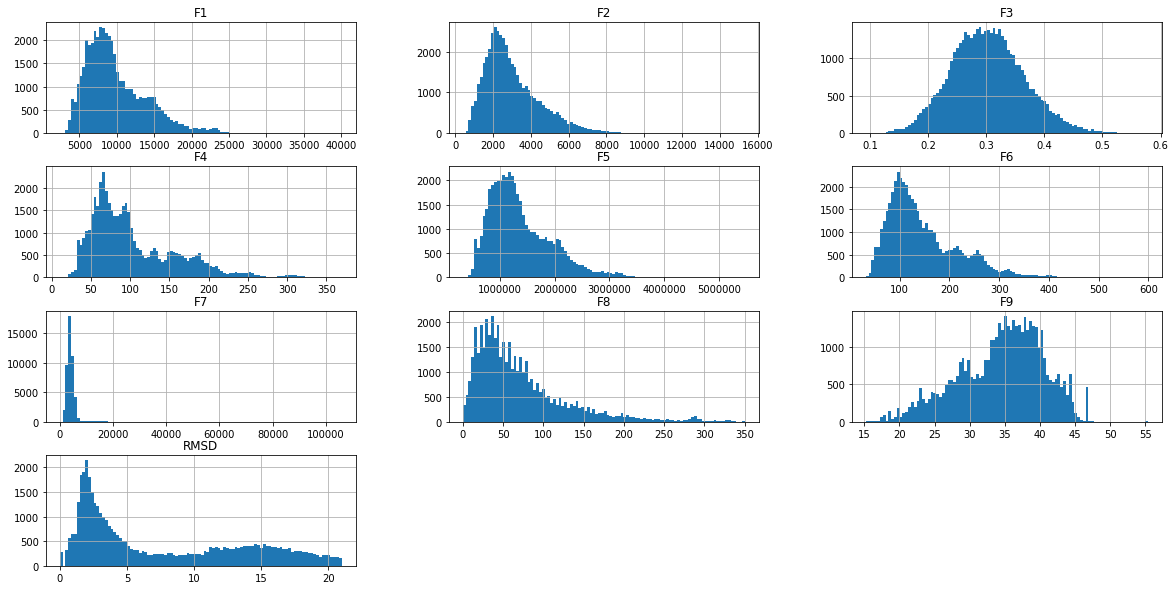

In [132]:
casp.hist(bins=100, figsize=(20,10));

Let us see if there is any missing data in the dataset

In [97]:
np.where(casp.values == np.nan)

(array([], dtype=int64), array([], dtype=int64))

In [98]:
def get_correlation(data):
    plt.figure(figsize=(15,10));
    pd.plotting.scatter_matrix(data, figsize=(20,10));

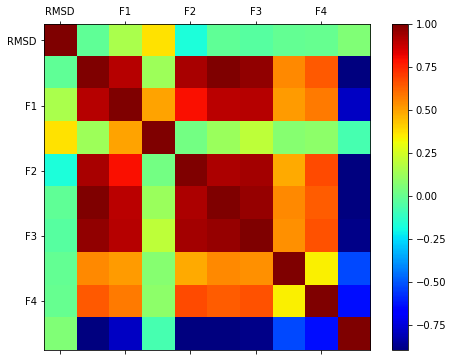

In [99]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
cax = ax.matshow(casp.corr(), cmap = 'jet', interpolation='none')
fig.colorbar(cax)

ax.set_xticklabels(['']+list(casp));
ax.set_yticklabels(['']+list(casp));

<Figure size 1080x720 with 0 Axes>

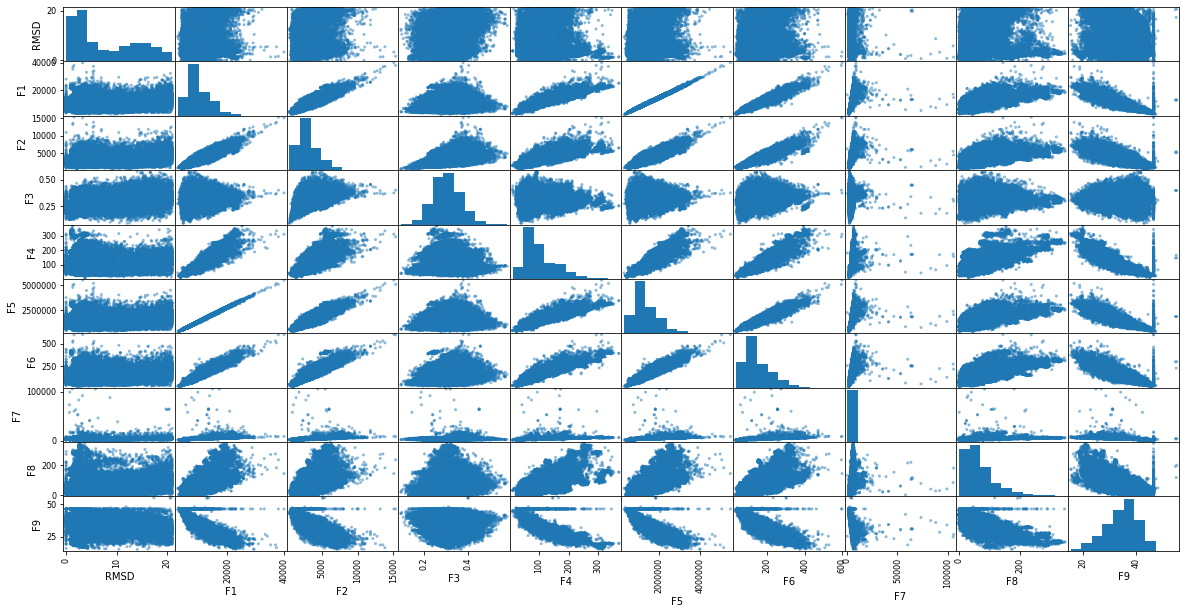

In [100]:
get_correlation(casp)

We notice here that the feature `F9` has been capped artificially to around its maximum value. Looking back in the histogram for `F9`, it is clear that there is a peak for bin between 45 and 50. 

Also `F7` appears to have  

In [101]:
casp.corr()['RMSD'].sort_values(ascending=False)

RMSD    1.000000
F3      0.374309
F2      0.156895
F9      0.062830
F8      0.000344
F7     -0.003339
F5     -0.013982
F1     -0.015087
F6     -0.036135
F4     -0.169771
Name: RMSD, dtype: float64

Text(0, 0.5, 'RMSD')

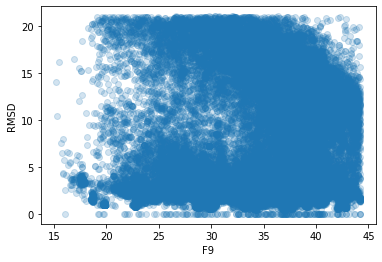

In [134]:
plt.scatter(casp["F9"], casp["RMSD"], alpha=0.2)
plt.xlabel("F9")
plt.ylabel("RMSD")

# Fit a linear regression model

Let us start with splitting the dataset into training set and test set

In [157]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(casp.drop("RMSD", axis=1),casp["RMSD"], test_size=0.3, random_state=42)

In [158]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

poly_features_pipeline = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3, include_bias=False)),
    ("minmax_scaler", MinMaxScaler())
])

X_train_scaled = poly_features_pipeline.fit_transform(X_train)

In [159]:
X_train_scaled.shape

(32011, 219)

In [160]:
print("Number of Features in the set " + str(X_train_scaled.shape[1]))

Number of Features in the set 219


We ended up with 219 features altogether. How did this happen? 

The formula to calculate the total number of polynomial features after transormation is *C(n+r,r)* (Combination), where *n* is the number of features in the dataset and *r* is the degree of polynomial. In our case, this translates to $C(9+3,3) = 12!/ (12-3)! 3! = 220$. Since we did not opt for the bias term, we ended up with one less than 220, i.e., 219.

In [161]:
from sklearn.linear_model import LinearRegression
import time
lin_reg = LinearRegression();

start_time = time.time()
lin_reg.fit(X_train_scaled, y_train)
print('Time taken ' + str(time.time() - start_time))

Time taken 0.7398889064788818


In [162]:
def plot_results(X, y, lin_reg_model, name):
    plt.figure(figsize=(6,6))
    y_pred = lin_reg_model.predict(X)
    plt.scatter(y_pred,y, alpha=0.2)
    plt.plot([y_pred.min(),y_pred.max()],[y.min(),y.max()],'k')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("R2 Score = " +str(r2_score(lin_reg_model.predict(X), y)))
    plt.savefig(name+'.svg', format='svg')

In [163]:
X_test_scaled = poly_features_pipeline.fit_transform(X_test)

In [164]:
from sklearn.metrics import mean_squared_error, r2_score
rmse_test = np.sqrt(mean_squared_error(lin_reg.predict(X_test_scaled),y_test))
rmse_train = np.sqrt(mean_squared_error(lin_reg.predict(X_train_scaled),y_train))
print("RMSE on train and test is ", rmse_train, rmse_test)

RMSE on train and test is  4.59728454182465 41.70974054504836


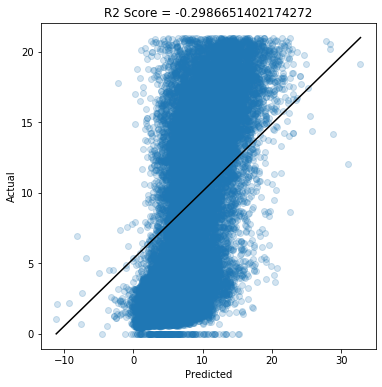

In [165]:
plot_results(X_train_scaled, y_train, lin_reg, "Without_PCA_Train")

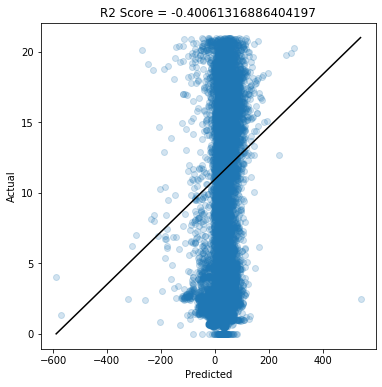

In [166]:
plot_results(X_test_scaled, y_test, lin_reg, "Without_PCA_Test")

In [173]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(casp.drop("RMSD", axis=1),casp["RMSD"], test_size=0.3, random_state=42)

In [174]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

scaler_pipeline = Pipeline([
    ("minmax_scaler", MinMaxScaler()),
    ("pca", PCA(n_components=0.99))
])
X_train_scaled = scaler_pipeline.fit_transform(X_train)

Transformation pipelines are very useful in machine learning especially when you have a sequence of transformations to be done.

Apart from this obvious benefit, pipelines also help in avoiding the data leakage issue. Essentially pipelines use `fit()` only on the training set while performing crossvalidation rather than on the entire training+validation set, thus allowing us to judge how the model performs on the unseen data.

In [175]:
pca_handle = scaler_pipeline.named_steps['pca']
pca_handle.explained_variance_ratio_.sum()

0.9936994761961224

In [176]:
X_train_scaled.shape

(32011, 5)

In [177]:
from sklearn.neural_network import MLPRegressor
import time
mlp_reg = MLPRegressor(random_state=42, max_iter=100, verbose=True);

start_time = time.time()
mlp_reg.fit(X_train_scaled, y_train)
print('Time taken ' + str(time.time() - start_time))

Iteration 1, loss = 40.95018762
Iteration 2, loss = 21.00784958
Iteration 3, loss = 15.63798843
Iteration 4, loss = 14.70834363
Iteration 5, loss = 14.10350671
Iteration 6, loss = 13.79919306
Iteration 7, loss = 13.60189465
Iteration 8, loss = 13.45324297
Iteration 9, loss = 13.33244237
Iteration 10, loss = 13.23471947
Iteration 11, loss = 13.15412140
Iteration 12, loss = 13.08427082
Iteration 13, loss = 13.02440605
Iteration 14, loss = 12.96616316
Iteration 15, loss = 12.91126218
Iteration 16, loss = 12.86442361
Iteration 17, loss = 12.82022287
Iteration 18, loss = 12.78123304
Iteration 19, loss = 12.73997522
Iteration 20, loss = 12.70749428
Iteration 21, loss = 12.68453184
Iteration 22, loss = 12.65125943
Iteration 23, loss = 12.62796003
Iteration 24, loss = 12.61394864
Iteration 25, loss = 12.59181902
Iteration 26, loss = 12.57272383
Iteration 27, loss = 12.55661689
Iteration 28, loss = 12.54747477
Iteration 29, loss = 12.53515743
Iteration 30, loss = 12.52353209
Iteration 31, loss 

/opt/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


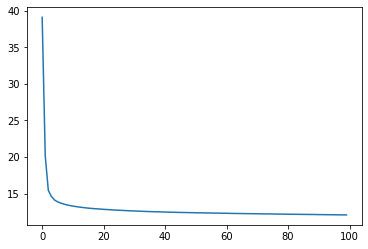

In [150]:
plt.plot(mlp_reg.loss_curve_)

In [151]:
def plot_results(X, y, lin_reg_model, name):
    plt.figure(figsize=(5,5))
    y_pred = lin_reg_model.predict(X)
    plt.scatter(y_pred,y, alpha=0.2)
    plt.plot([y_pred.min(),y_pred.max()],[y.min(),y.max()],'k')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("R2 Score = " +str(r2_score(lin_reg_model.predict(X), y)))
    plt.savefig(name+'.svg', format='svg')

In [152]:
X_test_scaled = scaler_pipeline.transform(X_test)

In [153]:
from sklearn.metrics import mean_squared_error, r2_score
rmse_test = np.sqrt(mean_squared_error(mlp_reg.predict(X_test_scaled),y_test))
rmse_train = np.sqrt(mean_squared_error(mlp_reg.predict(X_train_scaled),y_train))
print("RMSE on train and test is ", rmse_train, rmse_test)

RMSE on train and test is  4.911667754361561 4.896221683567282


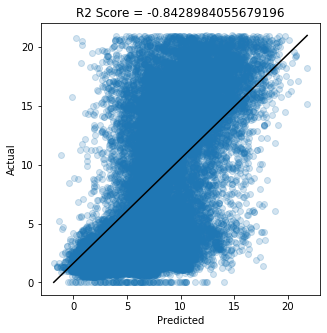

In [154]:
plot_results(X_train_scaled, y_train, mlp_reg, "Without_PCA_Train")

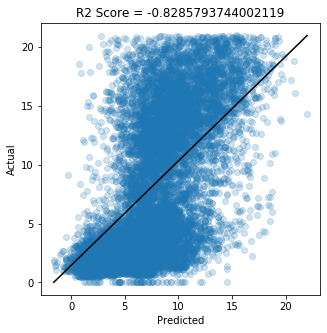

In [155]:
plot_results(X_test_scaled, y_test, mlp_reg, "Without_PCA_Test")